In [20]:
import torch
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(42)

In [21]:
# CIFAR images are 32x32
# We consider a simple 2x2 jigsaw puzzle.
# 0 1
# 3 2
perm_inds = [(0, 0), (16, 0), (16, 16), (0, 16)]
# Simply maps each pixel to [-1, 1]
img_mean = 0.5
img_std = 0.5
    
def permute2x2(images):
    """
    Splits the images into 2x2 = 4 pieces and randomly permutes the pieces.
    """
    p_images = torch.FloatTensor(images.size())
    perms = torch.LongTensor(images.size()[0], 4)
    for i in range(images.size()[0]):
        p = torch.randperm(4)
        for j in range(4):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[p[j]]
            p_images[i, :, tr:tr+16, tc:tc+16] = images[i, :, sr:sr+16, sc:sc+16]
        perms[i,:] = p
    return(p_images, perms)

def restore2x2(p_images, perms):
    """
    Restores the original image from the pieces and the given permutation.
    """
    images = torch.FloatTensor(p_images.size())
    for i in range(images.size()[0]):
        for j in range(4):
            sr, sc = perm_inds[j]
            tr, tc = perm_inds[perms[i, j]]
            images[i, :, sr:sr+16, sc:sc+16] = p_images[i, :, tr:tr+16, tc:tc+16]
    return images

def perm2vecmat2x2(perms):
    """
    Converts permutation vectors to vectorized assignment matrices.
    """
    n = perms.size()[0]
    mat = torch.zeros(n, 4, 4)
    # m[i][j] : i is assigned to j
    for i in range(n):
        for k in range(4):
            mat[i, k, perms[i, k]] = 1.
    return mat.view(n, -1)

def vecmat2perm2x2(x):
    """
    Converts vectorized assignment matrices back to permutation vectors.
    Note: this function is compatible with GPU tensors.
    """
    n = x.size()[0]
    x = x.view(n, 4, 4)
    _, ind = x.max(2)
    return ind
    
def imshow(img, title=None):
    """
    Displays a torch image.
    """
    img = img * img_std + img_mean
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title != None:
        plt.title(title)

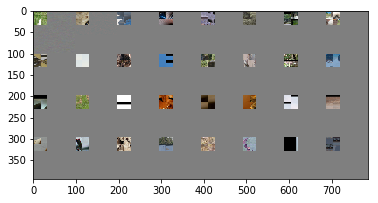

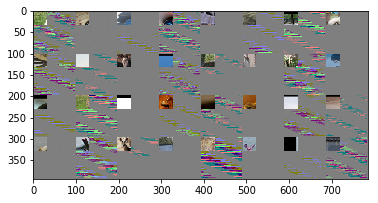

In [52]:
batch_size = 32
dataset_dir = './data'

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((img_mean, img_mean, img_mean), (img_std, img_std, img_std))])

train_set = torchvision.datasets.STL10(root=dataset_dir, download=True, transform=transform)

# Plot some training samples.
sample_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                            shuffle=True, num_workers=0)
dataiter = iter(sample_loader)
images, labels = next(dataiter)

p_images, perms = permute2x2(images)

# Check the implementation of per2vecmat and vecmat2perm.
assert(vecmat2perm2x2(perm2vecmat2x2(perms)).equal(perms))

# Show permuted images.
plt.figure()
imshow(torchvision.utils.make_grid(p_images))
# Show restored images.
plt.figure()
imshow(torchvision.utils.make_grid(restore2x2(p_images, perms)))

In [45]:
import torchvision.models as models
import torch.nn as nn
vgg16 = models.vgg16(pretrained=True)

In [46]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
    

In [48]:
sss = nn.Sequential(*[vgg16.features[i] for i in range(10)])
print(sss)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
)


In [50]:
sss

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
)